## 1. GridWorldBuilding <a id=online>

In [51]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [3]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(0,3))
        self.board.addPiece('Pit','-',(0,3))
        self.board.addPiece('Wall','W',(2,3))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = randPair(0,self.board.size) #Row, Column
        self.board.components['Goal'].pos = (3,0)
        self.board.components['Pit'].pos = (3,1)
        self.board.components['Wall'].pos = (3,2)
        
        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridStatic()


    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

## 2. Training of the Model <a id = "testing_online">

In [4]:
import torch
import numpy as np
from collections import deque
from IPython.display import clear_output


def dqn_training(l2, l3, learning_rate, gamma, epsilon, epochs, mem_size, batch_size, max_moves):
    
    action_set= {
        0: 'u',
        1: 'd',
        2: 'l',
        3: 'r',
    }
    l1 = 64
    l4 = 4

    model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3, l4)
    )
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    replay = deque(maxlen=mem_size)

    losses = []

    for i in range(epochs):
        game = Gridworld(size=4, mode='random')
        state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state1 = torch.from_numpy(state1_).float()
        status = 1
        mov = 0

        while status == 1:
            mov += 1
            qval = model(state1)
            qval_ = qval.data.numpy()

            if np.random.rand() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)

            action = action_set[action_]

            game.makeMove(action)
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state2 = torch.from_numpy(state2_).float()
            next_state = model(state2)
            next_state_ = next_state.data.numpy()

            reward = game.reward()

            if reward == -1 or reward == -10:
                Y = reward + (gamma * next_state_[0][np.argmax(next_state_)])
            else:
                Y = reward

            done = True if reward > 0 else False
            exp = (state1, action_, reward, state2, done)
            replay.append(exp)
            state1 = state2

            if len(replay) > batch_size:
                minibatch = random.sample(replay, batch_size)
                state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
                action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
                reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
                state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
                done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])

                Q1 = model(state1_batch)
                with torch.no_grad():
                    Q2 = model(state2_batch)

                Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
                X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
                loss = loss_fn(X, Y.detach())
                print(i)
                clear_output(wait=True)
                optimizer.zero_grad()
                loss.backward()
                losses.append(loss.item())
                optimizer.step()

            if reward != -1 or mov > max_moves:
                status = 0
                mov = 0

    losses = np.array(losses)

    return model, losses

In [5]:
l2 = 200
l3 = 120
learning_rate = 0.001
gamma = 0.9
epsilon = 0.3
epochs = 5000
mem_size = 1000
batch_size = 200
max_moves = 50

In [6]:
model, losses = dqn_training(l2, l3, learning_rate, gamma, epsilon, epochs, mem_size, batch_size, max_moves)

4999


Text(0, 0.5, 'Loss')

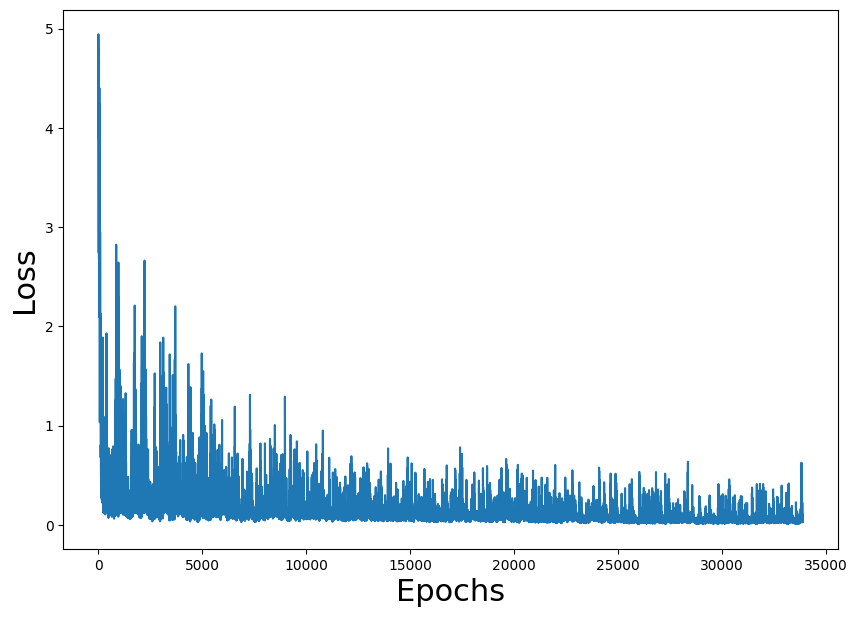

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

## 3. Testing of the Model <a id = "testing_online">

In [12]:
def dqn_test_model(model, mode='static', display=True):
    action_set= {
        0: 'u',
        1: 'd',
        2: 'l',
        3: 'r',
    }
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while status == 1:
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]

        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)

        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()

        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if i > 15:
            if display:
                print("Game lost; too many moves.")
            break

    win = True if status == 2 else False
    return win, i  # Return both win status and number of moves

In [13]:
def dqn_test_and_evaluate(model, max_games=10000, mode='random', display=False):
    wins = 0
    total_moves = 0

    for i in range(max_games):
        win, moves = dqn_test_model(model, mode=mode, display=display)
        total_moves += moves
        if win:
            wins += 1

    win_perc = float(wins) / float(max_games)
    average_moves = float(total_moves) / float(max_games)

    return win_perc, average_moves


In [14]:
# Example usage:
max_games = 10000
win_perc, average_moves = dqn_test_and_evaluate(model, max_games=max_games, mode='random', display=False)

print("Games played: {0}, # of wins: {1}".format(max_games, int(win_perc * max_games)))
print("Win percentage: {}%".format(win_perc * 100))
print("Average number of moves: {}".format(round(average_moves),2))

Games played: 10000, # of wins: 9398
Win percentage: 93.97999999999999%
Average number of moves: 3


## 4. Tests

In [72]:
!pytest -v test_sc_project.py

============================= test session starts =============================
platform win32 -- Python 3.8.10, pytest-7.4.3, pluggy-1.3.0 -- c:\Users\kuany\AppData\Local\Programs\Python\Python38\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\kuany\OneDrive\Рабочий стол\Project
collecting ... collected 5 items

test_sc_project.py::test_dqn_training_and_evaluation[Test 1: Default Parameters] PASSED [ 20%]
test_sc_project.py::test_dqn_training_and_evaluation[Test 2: Smaller Hidden Layer Sizes] PASSED [ 40%]
test_sc_project.py::test_dqn_training_and_evaluation[Test 3: Smaller Buffer size and Epoch] FAILED [ 60%]
test_sc_project.py::test_dqn_training_and_evaluation[Test 4: High Exploration Rate] PASSED [ 80%]
test_sc_project.py::test_dqn_training_and_evaluation[Test 5: Higher learning rate and Smaller Epoch] FAILED [100%]

================================== FAILURES ===================================
___ test_dqn_training_and_evaluation[Test 3: Smaller Buffer size and Epoch] ___

l

## 5. Packages

In [50]:
import nbformat


def extract_packages(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
        notebook_content = nbformat.read(notebook_file, as_version=4)

    packages = set()

    for cell in notebook_content['cells']:
        if cell['cell_type'] == 'code':
            source_code = cell['source']
            lines = source_code.split('\n')
            
            for line in lines:
                if line.startswith('import') or line.startswith('from'):
                    # Extracting the package/module name from import statements
                    parts = line.split()
                    if len(parts) >= 2:
                        package_name = parts[1].split('.')[0]
                        packages.add(package_name)

    return sorted(list(packages))

if __name__ == "__main__":
    notebook_path = 'SC_Project.ipynb'
    result = extract_packages(notebook_path)
    
    print("Packages used in the notebook:")
    for package in result:
        print(package)


Packages used in the notebook:
IPython
collections
matplotlib
numpy
random
sys
torch


In [57]:
def extract_packages_from_py(py_file_path):
    packages = set()

    with open(py_file_path, 'r', encoding='utf-8') as py_file:
        lines = py_file.readlines()

        for line in lines:
            # Extracting the package/module name from import statements
            if line.startswith('import') or line.startswith('from'):
                parts = line.split()
                if len(parts) >= 2:
                    package_name = parts[1].split('.')[0]
                    packages.add(package_name)

    return sorted(list(packages))

if __name__ == "__main__":
    python_file_path = 'test_sc_project.py'
    result = extract_packages_from_py(python_file_path)
    
    print("Packages used in the Python script:")
    for package in result:
        print(package)

Packages used in the Python script:
modules
pytest
